In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
import math
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
# Cargar el DataFrame original
df_original = pd.read_csv('df_merged.csv')

# Convertir la columna Fecha_venta a tipo datetime
df_original['Fecha_venta'] = pd.to_datetime(df_original['Fecha_venta'])

# Identificar las columnas numéricas (int y float)
numeric_columns = df_original.select_dtypes(include=[np.number]).columns

# Crear una copia del DataFrame para escalar las columnas numéricas
df_merged = df_original.copy()

In [3]:
def nan_counter(df):
    nan_polluted_series_counter = 0
    for column in df.columns:
        if df[column].isnull().sum() > 0:
            nan_polluted_series_counter += 1
    print(nan_polluted_series_counter)

In [4]:
nan_counter(df_merged)

0


In [5]:
# Aplicar MinMaxScaler a cada columna numérica
scaler = MinMaxScaler()
df_merged[numeric_columns] = scaler.fit_transform(df_merged[numeric_columns])

# Preparar los datos para MiniSom
data_for_som = df_merged[numeric_columns].values

# Calcular las dimensiones del SOM para un número reducido de clústeres
som_x = 3
som_y = 3

# Crear y entrenar el SOM
som = MiniSom(som_x, som_y, data_for_som.shape[1], sigma=0.3, learning_rate=0.1)
som.random_weights_init(data_for_som)
som.train(data_for_som, 50000)

# Obtener el mapeo de los nodos ganadores
win_map = som.win_map(data_for_som)

# Asignar los clústeres del SOM a cada muestra
clusters = [som.winner(sample) for sample in data_for_som]

# Obtener los centroides de los clústeres del SOM
centroides = np.array([som.get_weights()[x, y] for x in range(som_x) for y in range(som_y)])






In [6]:
# Aplicar K-means para reducir a menos clústeres
num_final_clusters = 3
kmeans = KMeans(n_clusters=num_final_clusters)
final_clusters = kmeans.fit_predict(centroides)

# Convertir los clústeres del SOM a los clústeres finales del K-means
som_clusters = np.array([final_clusters[som_x * x + y] for x, y in clusters])

In [7]:
# Agregar la columna de clústeres al DataFrame original
df_original['Cluster'] = som_clusters

# Mostrar una muestra del DataFrame con la nueva columna
print(df_original.head())



   ID_tienda Fecha_venta  ID_producto  Cant_vendidas  Facturacion  \
0       5201  2021-05-08       561818              6       1488.0   
1       5201  2021-05-08       562189              4       1076.0   
2       5201  2021-05-08       560779             36       9684.0   
3       5201  2021-05-08       560576              6       1614.0   
4       5201  2021-05-08       604216              2        458.0   

   Precio_unidad Dia_sem  Status  ID_proveedor  Categoria  Clasif_proveedor  \
0          248.0  Sábado       1         65987        216                 1   
1          269.0  Sábado       1         10214        216                 1   
2          269.0  Sábado       1         10214        216                 1   
3          269.0  Sábado       1         10214        216                 1   
4          229.0  Sábado       1         10214        216                 1   

  Promocion   Año  Mes  Lag_1  Rolling_Mean_7  Rolling_Std_7  Dia_del_Mes  \
0        No  2021    5   10.0    

In [8]:
df_original

,ID_tienda,Fecha_venta,ID_producto,Cant_vendidas,Facturacion,Precio_unidad,Dia_sem,Status,ID_proveedor,Categoria,Clasif_proveedor,Promocion,Año,Mes,Lag_1,Rolling_Mean_7,Rolling_Std_7,Dia_del_Mes,Cluster
0,5201,2021-05-08,561818,6,1488.0,248.0,Sábado,1,65987,216,1,No,2021,5,10.0,4.857143,3.023716,8,1
1,5201,2021-05-08,562189,4,1076.0,269.0,Sábado,1,10214,216,1,No,2021,5,5.0,3.714286,1.799471,8,1
2,5201,2021-05-08,560779,36,9684.0,269.0,Sábado,1,10214,216,1,No,2021,5,9.0,13.714286,10.387722,8,2
3,5201,2021-05-08,560576,6,1614.0,269.0,Sábado,1,10214,216,1,No,2021,5,3.0,2.571429,1.718249,8,1
4,5201,2021-05-08,604216,2,458.0,229.0,Sábado,1,10214,216,1,No,2021,5,3.0,2.142857,0.690066,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113249,5201,2024-04-30,600889,1,270.0,270.0,Martes,1,10145,216,1,No,2024,4,1.0,1.571429,1.133893,30,2
113250,5201,2024-04-30,600917,4,2320.0,580.0,Martes,1,10145,216,1,No,2024,4,1.0,1.428571,1.133893,30,2
113251,5201,2024-04-30,600918,1,580.0,580.0,Martes,1,10145,216,1,No,2024,4,1.0,1.142857,0.377964,30,2
113252,5201,2024-04-30,600922,1,379.0,379.0,Martes,1,10214,216,1,No,2024,4,1.0,2.000000,2.236068,30,2


In [9]:
# Definir la función para graficar el SOM
def plot_som_series_dba_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x, som_y, figsize=(15, 10))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x, y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[x, y].plot(series, c="gray", alpha=0.5)
                axs[x, y].plot(dtw_barycenter_averaging(np.vstack(win_map[cluster])), c="red")
            cluster_number = x * som_y + y + 1
            axs[x, y].set_title(f"Cluster {cluster_number}")
    plt.tight_layout()
    plt.show()

# Definir la función para graficar el SOM con los clústeres fusionados
def plot_final_clusters(som_x, som_y, win_map, final_clusters):
    fig, axs = plt.subplots(1, num_final_clusters, figsize=(15, 5))
    fig.suptitle('Final Clusters')
    for cluster_id in range(num_final_clusters):
        cluster_indices = np.where(final_clusters == cluster_id)[0]
        for idx in cluster_indices:
            x, y = divmod(idx, som_y)
            if (x, y) in win_map.keys():
                for series in win_map[(x, y)]:
                    axs[cluster_id].plot(series, c="gray", alpha=0.5)
                axs[cluster_id].plot(dtw_barycenter_averaging(np.vstack(win_map[(x, y)])), c="red")
        axs[cluster_id].set_title(f"Final Cluster {cluster_id + 1}")
    plt.tight_layout()
    plt.show()

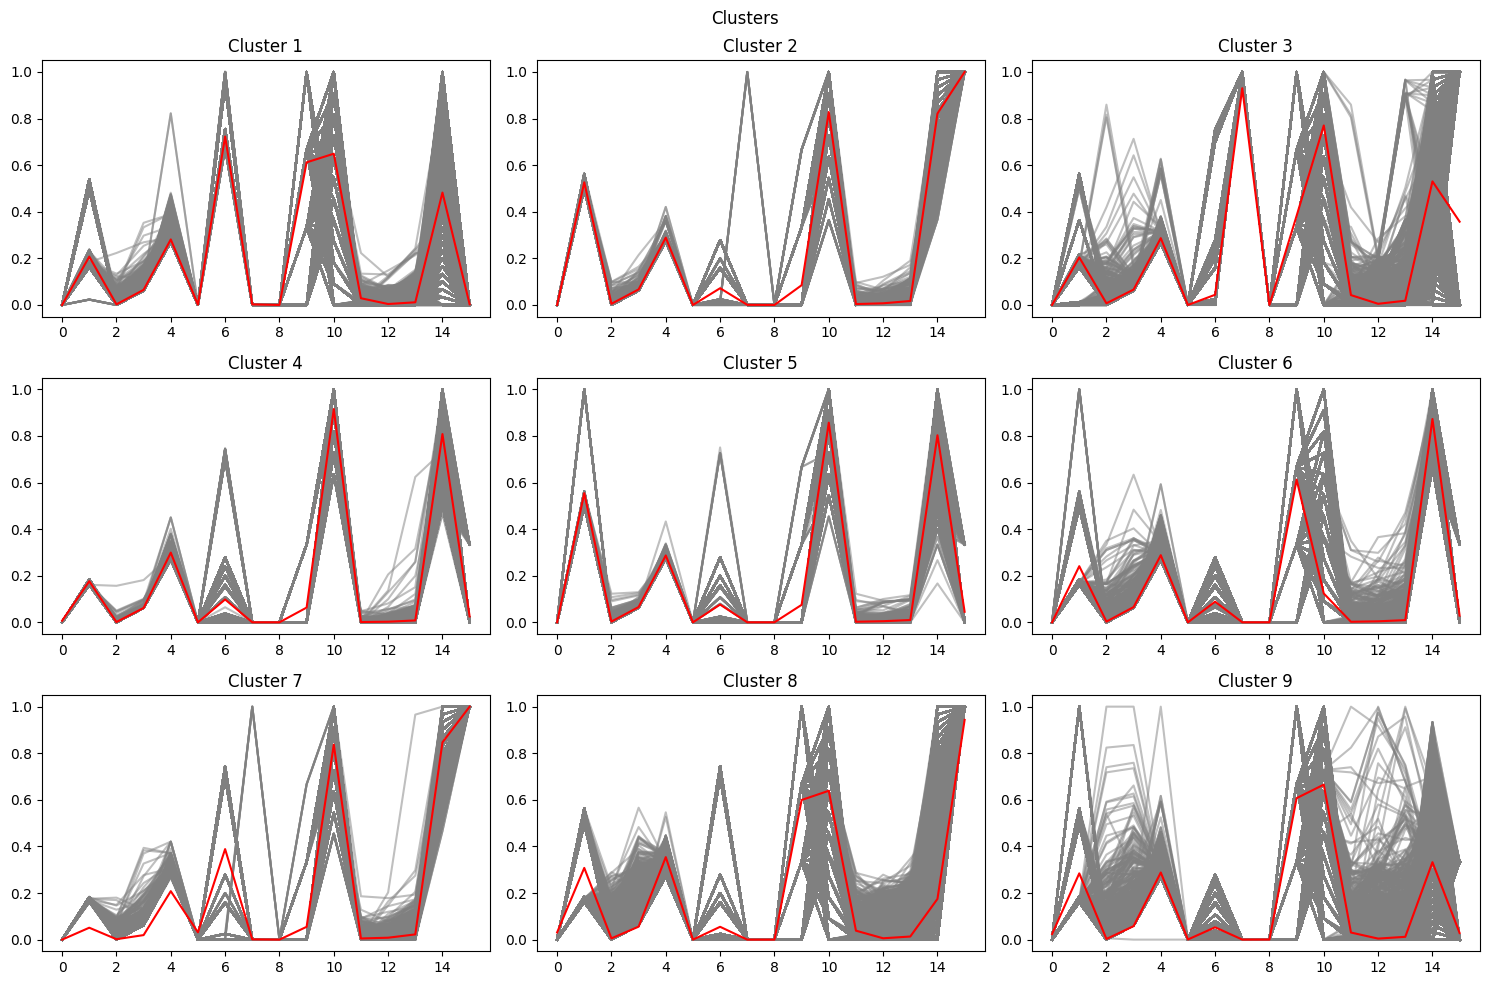

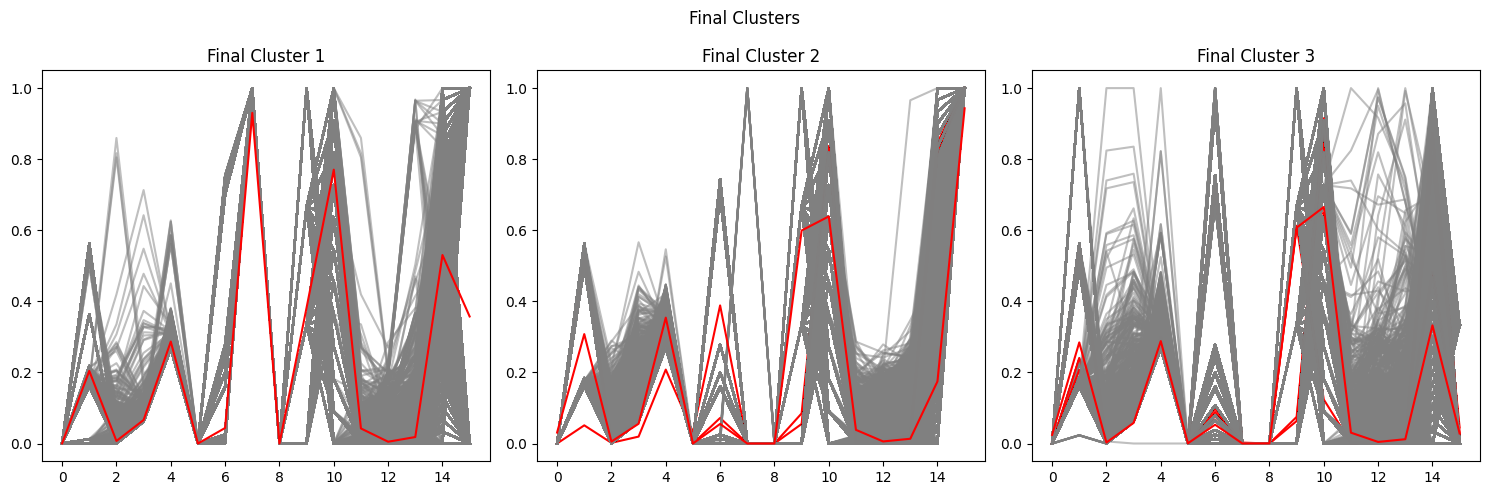

In [10]:
# Graficar el SOM con los nodos ganadores (código existente)
plot_som_series_dba_center(som_x, som_y, win_map)
plot_final_clusters(som_x, som_y, win_map, final_clusters)

In [11]:
df_original

,ID_tienda,Fecha_venta,ID_producto,Cant_vendidas,Facturacion,Precio_unidad,Dia_sem,Status,ID_proveedor,Categoria,Clasif_proveedor,Promocion,Año,Mes,Lag_1,Rolling_Mean_7,Rolling_Std_7,Dia_del_Mes,Cluster
0,5201,2021-05-08,561818,6,1488.0,248.0,Sábado,1,65987,216,1,No,2021,5,10.0,4.857143,3.023716,8,1
1,5201,2021-05-08,562189,4,1076.0,269.0,Sábado,1,10214,216,1,No,2021,5,5.0,3.714286,1.799471,8,1
2,5201,2021-05-08,560779,36,9684.0,269.0,Sábado,1,10214,216,1,No,2021,5,9.0,13.714286,10.387722,8,2
3,5201,2021-05-08,560576,6,1614.0,269.0,Sábado,1,10214,216,1,No,2021,5,3.0,2.571429,1.718249,8,1
4,5201,2021-05-08,604216,2,458.0,229.0,Sábado,1,10214,216,1,No,2021,5,3.0,2.142857,0.690066,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113249,5201,2024-04-30,600889,1,270.0,270.0,Martes,1,10145,216,1,No,2024,4,1.0,1.571429,1.133893,30,2
113250,5201,2024-04-30,600917,4,2320.0,580.0,Martes,1,10145,216,1,No,2024,4,1.0,1.428571,1.133893,30,2
113251,5201,2024-04-30,600918,1,580.0,580.0,Martes,1,10145,216,1,No,2024,4,1.0,1.142857,0.377964,30,2
113252,5201,2024-04-30,600922,1,379.0,379.0,Martes,1,10214,216,1,No,2024,4,1.0,2.000000,2.236068,30,2


In [ ]:
df_original

In [12]:
df_original.to_csv('df_original.csv', index=False)